<a href="https://colab.research.google.com/github/theSC0RP/PyTorch-Deep-Learning/blob/master/Sparse.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch
from torchvision import transforms, datasets

In [2]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

trainset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

testset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

9920512it [00:00, 20896379.07it/s]                            


Extracting /root/.pytorch/MNIST_data/MNIST/raw/train-images-idx3-ubyte.gz to /root/.pytorch/MNIST_data/MNIST/raw


32768it [00:00, 328736.84it/s]
0it [00:00, ?it/s]

Extracting /root/.pytorch/MNIST_data/MNIST/raw/train-labels-idx1-ubyte.gz to /root/.pytorch/MNIST_data/MNIST/raw


1654784it [00:00, 5332272.47it/s]                           
8192it [00:00, 131360.13it/s]


Extracting /root/.pytorch/MNIST_data/MNIST/raw/t10k-images-idx3-ubyte.gz to /root/.pytorch/MNIST_data/MNIST/raw
Extracting /root/.pytorch/MNIST_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to /root/.pytorch/MNIST_data/MNIST/raw
Processing...
Done!


In [3]:
trainset.data.size()

torch.Size([60000, 28, 28])

In [4]:
testset.data.size()

torch.Size([10000, 28, 28])

In [0]:
images, labels = next(iter(trainloader))

tensor(4) tensor(0) tensor(2) tensor(6) tensor(1) tensor(0) tensor(6) tensor(3) tensor(6) tensor(2) 

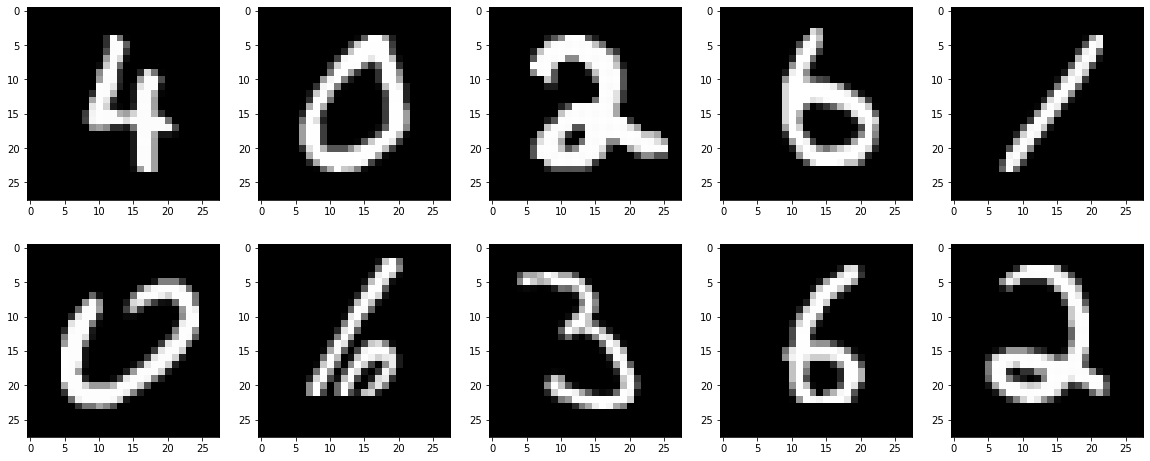

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize = (20, 8))
for i in range(10):
  print(labels[i], end = " ")
  plt.subplot(2, 5, i+1)
  plt.imshow(images[i].squeeze(), 'gray')

In [0]:

from torch import nn
from torch.nn import Linear, ReLU, LogSoftmax
def initNet():
  class Network(nn.Module):
    def __init__(self):
      super(Network, self).__init__()

      self.hidden1 = Linear(28 * 28, 1000, bias=False)
      self.hidden2 = Linear(1000, 1000, bias=False)
      self.hidden3 = Linear(1000, 500, bias=False)
      self.hidden4 = Linear(500, 200, bias=False)
      self.output = Linear(200, 10, bias=False)

      self.relu = ReLU()
      self.log_softmax = LogSoftmax(dim = 1)

    def forward(self, x):
      x = self.relu(self.hidden1(x))
      x = self.relu(self.hidden2(x))
      x = self.relu(self.hidden3(x))
      x = self.relu(self.hidden4(x))
      x = self.log_softmax(self.output(x)) 

      return x 

  model = Network()
  model = model.to('cuda')
  model = nn.DataParallel(model)

  return model

In [0]:
model = initNet()

In [0]:
learning_rate = 0.003
num_epochs = 10

criterion = nn.NLLLoss() 
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

In [0]:
def train():
  for e in range(num_epochs):
    running_loss = 0
    correct = 0
    for images, labels in trainloader:
      images = images.view(images.shape[0], -1)
      images = images.to('cuda')
      labels = labels.to('cuda')

      outputs = model(images)
      loss = criterion(outputs, labels)
      (max_vals, arg_maxs) = torch.max(outputs.data, dim=1)
      correct += torch.sum(labels == arg_maxs)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      running_loss += loss.item()

In [0]:
def test():
  correct = 0
  with torch.no_grad():
    for images, labels in testloader:
      images = images.view(images.shape[0], -1)
      images = images.to('cuda')
      labels = labels.to('cuda')

      outputs = model(images)
      loss = criterion(outputs, labels)
      (max_vals, arg_maxs) = torch.max(outputs.data, dim=1)
      correct += torch.sum(labels == arg_maxs)

  return correct.item()/100.0

# Weight Pruning

In [0]:
train()

In [0]:
k_list = [0, .25, .50, .60, .70, .80, .90, .95, .97, .99]

In [0]:
def pruneLayerWeights(layer_weights, thresh):
  for i in range(layer_weights.shape[0]):
    for j in range(layer_weights.shape[1]):
      if abs(layer_weights[i][j]) <= thresh:
        layer_weights[i][j] = 0

In [0]:
def getThreshs(w):
  vals = abs(w.cpu().flatten()).sort().values
  print(vals.shape)
  threshs = [round(vals[int(vals.shape[0] * k)].item(), 4) for k in k_list]
  return threshs

In [16]:
w1 = model.module.hidden1.weight.data
t1 = getThreshs(w1)
print(t1)

w2 = model.module.hidden2.weight.data
t2 = getThreshs(w2)
print(t2)

w3 = model.module.hidden3.weight.data
t3 = getThreshs(w3)
print(t3)

w4 = model.module.hidden4.weight.data
t4 = getThreshs(w4)
print(t4)

torch.Size([784000])
[0.0, 0.0092, 0.019, 0.0248, 0.0319, 0.0393, 0.0472, 0.0523, 0.0623, 0.2276]
torch.Size([1000000])
[0.0, 0.0081, 0.0177, 0.0232, 0.0288, 0.0355, 0.0433, 0.0478, 0.0514, 0.1626]
torch.Size([500000])
[0.0, 0.0119, 0.0283, 0.037, 0.0473, 0.0791, 0.1468, 0.2206, 0.2766, 0.396]
torch.Size([100000])
[0.0, 0.0175, 0.0378, 0.0491, 0.0642, 0.0973, 0.1524, 0.2083, 0.2503, 0.3417]


In [17]:
test_accs = [test()]
print(test_accs)
for i in range(1, len(k_list)):
  pruneLayerWeights(w1, t1[i])
  pruneLayerWeights(w2, t2[i])
  pruneLayerWeights(w3, t3[i])
  pruneLayerWeights(w4, t4[i])

  test_i_acc = test()
  print(test_i_acc)
  test_accs.append(test_i_acc)

[96.41]
96.49
96.54
96.65
96.6
96.56
96.37
94.7
79.22
21.57


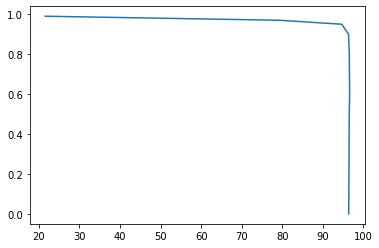

In [18]:
import matplotlib.pyplot as plt
plt.plot(test_accs, k_list)

# Node Pruning

In [0]:
model = initNet()

In [0]:
learning_rate = 0.003
num_epochs = 10

criterion = nn.NLLLoss() 
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

In [0]:
train()

In [0]:
k_list = [0, .25, .50, .60, .70, .80, .90, .95, .97, .99]

In [0]:
def getL2Dicts(w):
	d = {}
	for i in range(w.shape[1]):
		d[i] = torch.sum(w[:, i] ** 2)
	list_sorted_dict_tuples = sorted(d.items(), key=lambda x: x[1])
	return list_sorted_dict_tuples

In [0]:
def getL2Threshs(list_tuples):
  threshs = []
  for k in k_list:
    thresh = list_tuples[int(len(list_tuples) * k)][1]
    threshs.append(thresh)
  return threshs

In [0]:
def getColIndices(list_tuples, thresh):
  indices = []
  for tup in list_tuples:
    if tup[1] <= thresh:
      indices.append(tup[0])
    else:
      break
  return indices

In [0]:
def pruneCols(w, indices):
	for i in indices:
		w[:, i] = 0

In [0]:
w1 = model.module.hidden1.weight.data
w2 = model.module.hidden2.weight.data
w3 = model.module.hidden3.weight.data
w4 = model.module.hidden4.weight.data

weights = [w1, w2, w3, w4]
list_list_tuples, list_threshs, list_indices = [], [], []
for w in weights:
  list_tups = getL2Dicts(w)
  list_list_tuples.append(list_tups)

  list_threshs.append(getL2Threshs(list_tups))

In [28]:
node_test_accs = [test()]
print(node_test_accs)

for i in range(1, len(k_list)):
  for j in range(4):
    cols = getColIndices(list_list_tuples[j], list_threshs[j][i])
    pruneCols(weights[j], cols)

  acc = test()
  print(acc)
  node_test_accs.append(acc)

[96.77]
89.47
70.7
65.68
67.86
62.22
42.51
25.58
22.58
11.23


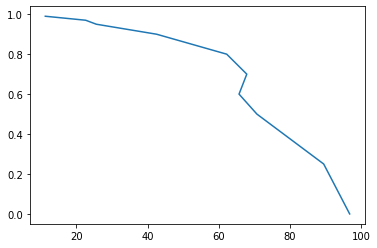

In [29]:
import matplotlib.pyplot as plt
plt.plot(node_test_accs, k_list)